In [32]:
import numpy as np
import torch.nn as nn
import torch
import torch.autograd as autograd
from torch.nn import init
import torch.nn.utils.rnn 
from torch.nn.utils.rnn import pad_sequence
import datetime
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import unicodedata
import string
import re
import random
import os
import itertools
import warnings
warnings.filterwarnings('ignore')

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Dialog pairs consist of [context, response, label]
def get_dialog_pairs(dataset, evalset):
    dataset_length = len(dataset)
    dialog_pairs = []
    for i in range(dataset_length):
        conv_length = len(dataset[i])
        for j in range(1,conv_length):
            if isinstance(dataset[i][j-1], str):
                inputLine = dataset[i][j-1].strip()
            else:
                inputLine = dataset[i][j-1]['text'].strip() 
            if not inputLine or not isinstance(inputLine, str): 
                inputLine = 'Nothing'
            if isinstance(dataset[i][j], str):
                targetLine = dataset[i][j].strip()
            else:
                targetLine = dataset[i][j]['text'].strip() 
            if not targetLine or not isinstance(targetLine, str): 
                targetLine = 'Nothing'
            if isinstance(inputLine, str) and isinstance(targetLine, str) and inputLine and targetLine:
                if evalset[i] >= 2:
                    label = 1
                else:
                    label = 0
                inputLine = normalizeString(inputLine)
                targetLine = normalizeString(targetLine)
                dialog_pairs.append([inputLine, targetLine, label])

    return dialog_pairs

In [35]:
# Get list of individual sentences
def get_dialog(dataset):
    dataset_length = len(dataset)
    dialog = []
    for i in range(dataset_length):
        conv_length = len(dataset[i])
        
        for j in range(1,conv_length):
            if isinstance(dataset[i][j-1], str):
                inputLine = dataset[i][j-1].strip()
            else:
                inputLine = dataset[i][j-1]['text'].strip()
                
            if not isinstance(inputLine, str) or not inputLine or len(inputLine.split()) <= 0: 
                continue
            inputLine = normalizeString(inputLine)
            dialog.append([inputLine])

    return dialog

In [36]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [37]:
def normalizeString(s):
    if isinstance(s, str): 
        s = unicodeToAscii(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
        s = re.sub(r"\s+", r" ", s).strip()
    return s

In [38]:
def shuffle_list(list):
    random.shuffle(list)

def create_vocab(dialog):
    vocab = []
    word_freq = {}
    
    for sentence in dialog:
        sen = "".join(c for c in sentence)
        train_words = str(sen).split(" ")
        
        for word in train_words:
          
            if word.lower() not in vocab:
                vocab.append(word.lower())         
                       
            if word.lower() not in word_freq:
                word_freq[word.lower()] = 1
            else:
                #type(word)
                word_freq[word] += 1
    
    word_freq_sorted = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)
    vocab = ["<UNK>"] + [pair[0] for pair in word_freq_sorted]
    
    return vocab


def create_word_to_id(vocab):             
    word_to_id = {word: id for id, word in enumerate(vocab)}
    
    return word_to_id


def create_id_to_vec(word_to_id, glovefile): 
    lines = open(glovefile, 'r', encoding='utf-8').readlines()
    id_to_vec = {}
    vector = None
    
    for line in lines:
        word = line.split()[0]
        vector = np.array(line.split()[1:], dtype='float32') #32
        
        if word in word_to_id:
            id_to_vec[word_to_id[word]] = torch.FloatTensor(torch.from_numpy(vector))
            
    for word, id in word_to_id.items(): 
        if word_to_id[word] not in id_to_vec:
            v = np.zeros(*vector.shape, dtype='float32')
            v[:] = np.random.randn(*v.shape)*0.01
            id_to_vec[word_to_id[word]] = torch.FloatTensor(torch.from_numpy(v))
            
    embedding_dim = id_to_vec[0].shape[0]
    
    return id_to_vec, embedding_dim

def load_id(sentence, word_to_id):
    sentence_ids = []

    max_sentence_len = 160
    
    sentence_words = sentence.split()
    if len(sentence_words) > max_sentence_len:
        sentence_words = sentence_words[:max_sentence_len]
    for word in sentence_words:
        if word in word_to_id:
            sentence_ids.append(word_to_id[word])
        else: 
            sentence_ids.append(0) #UNK

    return sentence_ids

In [39]:
class Voc:
    def __init__(self):
        self.vocab = {}
        self.sentences = []
        self.word2id = {}
        self.id2vec = None
        
    def save(self):
        torch.save({
                'voc_dict': self.__dict__,
            }, os.path.join('saveDir', 'save_voc2.tar'))
    
    def load(self, filename):
        checkpoint = torch.load(filename)
        self.__dict__ = checkpoint['voc_dict']

In [40]:
class Temp:
    def __init__(self):
        self.training = []
        self.validation = []
        self.voc = []
        
    def save(self):
        torch.save({
                'temp_dict': self.__dict__,
            }, os.path.join('saveDir', 'save_temp.tar'))
    
    def load(self, filename):
        checkpoint = torch.load(filename)
        self.__dict__ = checkpoint['temp_dict']

In [41]:
def prepareData(embedding_dim):
    print("Start preparing training data ...")
    raw_dataset = load_dataset("conv_ai_2")
    raw_dataset1 = load_dataset("daily_dialog")
    train_dataset = raw_dataset["train"]
    train_dataset1 = raw_dataset1["train"]
    raw_dialog_list = train_dataset["dialog"]
    raw_dialog_list1 = train_dataset1["dialog"]
    
    eval_list = train_dataset["eval_score"]
    eval_list1 = [2 for i in range(len(raw_dialog_list1))]
    
    dialog_pairs = get_dialog_pairs(raw_dialog_list, eval_list)
    dialog_pairs1 = get_dialog_pairs(raw_dialog_list1, eval_list1)
    dialog_pairs.extend(dialog_pairs1)
    only_dialog_pairs = []
    for i in range(len(dialog_pairs)):
        only_dialog_pairs.append(dialog_pairs[i][0:2])
    
    dialog_indiv = get_dialog(raw_dialog_list)
    dialog_indiv1 = get_dialog(raw_dialog_list1)
    dialog_indiv.extend(dialog_indiv1)
    
    trimmed_sentences = []
    for s in dialog_indiv:
        if isinstance(s[0], str) and len(s[0].split()) < 15:
            trimmed_sentences.append(s)
    
    vocab = create_vocab(trimmed_sentences)
    voc = Voc()
    voc.vocab = vocab
    voc.sentences = trimmed_sentences
    shuffle_list(dialog_pairs)
            
    # Trim pairs to max 14 words and under
    trimmed_pairs = []
    for pair in dialog_pairs:
        if isinstance(pair[0], str) and len(pair[0].split()) < 15 and isinstance(pair[1], str) and len(pair[1].split()) < 15:
            trimmed_pairs.append(pair)
    
    #training_data = trimmed_pairs
    training_data = trimmed_pairs[:-(int(len(trimmed_pairs) / 20))]
    
    word_to_id = create_word_to_id(vocab)
    voc.word2id = word_to_id
    id_to_vec, emb_dim = create_id_to_vec(word_to_id, 'saveDir/GloVe/glove.6B.%dd.txt' %embedding_dim)
    voc.id2vec = id_to_vec
    voc.save()

    validation_data = trimmed_pairs[-(int(len(trimmed_pairs) / 20)):]
    
    return training_data, validation_data, voc

In [57]:
class LEncoder(nn.Module):
    def __init__(self, embed_size, hidden_size, layers, bi_dir, vocab_size, id_to_vec, dropout):
        super(LEncoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.layers = layers
        self.direction = bi_dir
        self.id_to_vec = id_to_vec
        self.dropout = dropout
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_size, dropout=self.dropout)
        
        embedding_weights = torch.FloatTensor(self.vocab_size, self.hidden_size)
        embedding_weights = embedding_weights.to(device)
        for id, vec in self.id_to_vec.items():
            embedding_weights[id] = vec

        self.embedding.weight = nn.Parameter(embedding_weights, requires_grad = False)

    def initHiddenCell(self):
        rand_hidden = autograd.Variable(torch.randn(1, 1, self.hidden_size))
        rand_cell = autograd.Variable(torch.randn(1, 1, self.hidden_size))
        return rand_hidden, rand_cell

    def forward(self, input_id, hidden, cell):
        tensor_input = torch.LongTensor([input_id])
        tensor_input = tensor_input.to(device)
        embed_input = self.embedding(tensor_input).view(1, 1, -1)
        output, (hidden, cell) = self.lstm(embed_input, (hidden, cell))
        return output, hidden, cell


class Dual_Encoder(nn.Module):
    def __init__(self, encoder):
        super(Dual_Encoder, self).__init__()

        self.encoder = encoder

        self.input_dim = 5 * self.encoder.hidden_size
        
        self.classifier = nn.Sequential(
            nn.Linear(self.input_dim, int(self.input_dim/2)),
            nn.Linear(int(self.input_dim/2), 2)
        )

    def forward(self, s1, s2):

        # init hidden, cell
        h1, c1 = self.encoder.initHiddenCell()
        h2, c2 = self.encoder.initHiddenCell()
        h1 = h1.to(device)
        c1 = c1.to(device)
        h2 = h2.to(device)
        c2 = c2.to(device)

        for i in range(len(s1)):
            v1, h1, c1 = self.encoder(s1[i], h1, c1)

        for j in range(len(s2)):
            v2, h2, c2 = self.encoder(s2[j], h2, c2)
        

        # utilize these two encoded vectors
        features = torch.cat((v1,torch.abs(v1 - v2),v2,v1*v2, (v1+v2)/2), 2)
        output = self.classifier(features)

        return output

In [58]:
def creating_model(embed_size, hidden_size, layers, bi_dir, vocab_size, id_to_vec, dropout):

    encoder = LEncoder(
            embed_size = embed_size,
            hidden_size = hidden_size,
            layers = layers,
            bi_dir = bi_dir,
            vocab_size = vocab_size,
            id_to_vec = id_to_vec,
            dropout = dropout)

    dual_encoder = Dual_Encoder(encoder)
    
    return encoder, dual_encoder

In [68]:
def trainIterAll(training_data, validation_data, voc, c_encoder, learning_rate, l2_penalty, epochs, filename=None):
    train_loss_list = []
    validation_loss_list = []
    best_loss = 10.0
    start_epoch = 0
    optimizer = torch.optim.Adam(c_encoder.parameters(), lr = learning_rate, weight_decay = l2_penalty)
    
    if filename:
        # If loading checkpoint
        print('Loading saved checkpoint')
        checkpoint = torch.load(filename)
        encoder_sd = checkpoint['en']
        encoder_optimizer_sd = checkpoint['opt']
        start_epoch = checkpoint['epoch'] + 1
        train_loss_list = checkpoint['t_loss']
        validation_loss_list = checkpoint['v_loss']
        voc.__dict__ = checkpoint['voc_dict']
        
        c_encoder.load_state_dict(encoder_sd)
        optimizer.load_state_dict(encoder_optimizer_sd)
    
    loss_weights = autograd.Variable(torch.FloatTensor([3, 1]))
    loss_func = torch.nn.CrossEntropyLoss(loss_weights)
    loss_func = loss_func.to(device)
    total_training_accuracy = 0
    best_validation_accuracy = 0
    best_training_accuracy = 0
    
    
    word_to_id = voc.word2id
    
    for epoch in range(start_epoch, epochs):

        # Initializations
        start_iteration = 1
        print_loss = 0

        train_loss = []
        train_loss_sum = []

        # Training loop
        c_encoder.train()
        i = 0
        n_iteration = len(training_data)
        shuffle_list(training_data)
        for data in training_data:
            optimizer.zero_grad()
            
            context, response, label = data
            context_ids = load_id(context, word_to_id)
            response_ids = load_id(response, word_to_id)
            
            # Run a training iteration with batch
            output = c_encoder(context_ids, response_ids)
            output = output.squeeze(0)

            # loss backward
            labl = autograd.Variable(torch.LongTensor([label]), requires_grad = False)#torch.LongTensor(label)
            labl = labl.to(device)
            loss = loss_func(output, labl)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.data.cpu())
            train_loss_sum.append(loss.data.cpu())

            # Print progress
            print_loss += loss
            if i % 5000 == 0:
                print_loss_avg = print_loss / 5000
                print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}; Mean train loss: {:.4f}".format(i, i / n_iteration * 100, print_loss_avg, np.mean(train_loss)))
                print_loss = 0
                train_loss = []
            i += 1
            
        # Record at every epoch
        print('Train Loss at epoch{}: {}\n'.format(epoch, np.mean(train_loss_sum)))
        train_loss_list.append(np.mean(train_loss_sum))
        
        c_encoder.eval()
        print("Going through validation data")
        # Iterate through validation set
        sum_loss_validation = []
        shuffle_list(validation_data)
        for data in validation_data:
            
            context, response, label = data
            context_ids = load_id(context, word_to_id)
            response_ids = load_id(response, word_to_id)
            
            # Run a validation iteration with batch
            output = c_encoder(context_ids, response_ids)
            output = output.squeeze(0)
            
            # loss
            labl = autograd.Variable(torch.LongTensor([label]), requires_grad = False)
            labl = labl.to(device)
            loss = loss_func(output, labl)
            sum_loss_validation.append(loss.data.cpu())
            
        print("Validation loss: {:.4f}".format(np.mean(sum_loss_validation)))
        validation_loss_list.append(np.mean(sum_loss_validation))

        print(str(datetime.datetime.now()).split('.')[0], 
              "Epoch: %d/%d" %(epoch,epochs))

        # Saving best result
        if np.mean(sum_loss_validation) < best_loss:
            best_record = np.mean(sum_loss_validation)
            print("Saving new best")
            torch.save({
                        'en': c_encoder.state_dict(),
                        'opt': optimizer.state_dict(),
                        'epoch': epoch,
                        't_loss': train_loss_list,
                        'v_loss': validation_loss_list,
                        'voc_dict': voc.__dict__
                }, os.path.join('saveDir', 'retrieval_model1.tar'))
        # Save checkpoint after each epoch
        torch.save({
                'en': c_encoder.state_dict(),
                'opt': optimizer.state_dict(),
                'epoch': epoch,
                't_loss': train_loss_list,
                'v_loss': validation_loss_list,
                'voc_dict': voc.__dict__
            }, os.path.join('saveDir', '{}_{}.tar'.format('retrieval_model', epoch)))
            
    print(str(datetime.datetime.now()).split('.')[0], "Training and validation epochs finished.")
    

In [69]:
filename = 'saveDir/save_temp.tar'
temp1 = Temp()
temp1.load(filename)

In [70]:
#n_iteration = 8000
#batch_size = 64
#training_data, validation_data, voc = prepareData(50)
training_data = temp1.training
validation_data = temp1.validation
voc = temp1.voc

In [71]:
len(training_data)

68522

In [72]:
embed_size = 50
hidden_size = 50
vocab_size = len(voc.vocab)
id_to_vec = voc.id2vec
layers = 1
bi_dir = 1
encoder, dual_encoder = creating_model(embed_size, hidden_size, layers, bi_dir, vocab_size, id_to_vec, dropout = 0.1)

encoder = encoder.to(device)
dual_encoder = dual_encoder.to(device)

In [73]:
trainIterAll(training_data = training_data, validation_data = validation_data, voc = voc, c_encoder = dual_encoder, learning_rate = 0.0001, l2_penalty = 0.000001, epochs = 20, filename='saveDir/retrieval_model.tar')

Loading saved checkpoint
Iteration: 0; Percent complete: 0.0%; Average loss: 0.0000; Mean train loss: 0.0009
Iteration: 5000; Percent complete: 7.3%; Average loss: 0.1892; Mean train loss: 0.1892
Iteration: 10000; Percent complete: 14.6%; Average loss: 0.2109; Mean train loss: 0.2109
Iteration: 15000; Percent complete: 21.9%; Average loss: 0.2130; Mean train loss: 0.2130
Iteration: 20000; Percent complete: 29.2%; Average loss: 0.2071; Mean train loss: 0.2071
Iteration: 25000; Percent complete: 36.5%; Average loss: 0.2087; Mean train loss: 0.2087
Iteration: 30000; Percent complete: 43.8%; Average loss: 0.2027; Mean train loss: 0.2027
Iteration: 35000; Percent complete: 51.1%; Average loss: 0.2093; Mean train loss: 0.2093
Iteration: 40000; Percent complete: 58.4%; Average loss: 0.2002; Mean train loss: 0.2002
Iteration: 45000; Percent complete: 65.7%; Average loss: 0.1897; Mean train loss: 0.1897
Iteration: 50000; Percent complete: 73.0%; Average loss: 0.2083; Mean train loss: 0.2083
Ite

In [94]:
checkpoint = torch.load('SaveDir/retrieval_model_12.tar')
train_loss_list = checkpoint['t_loss']
validation_loss_list = checkpoint['v_loss']

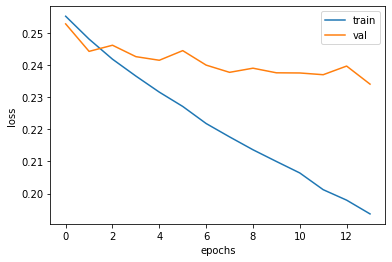

In [95]:
plt.plot(train_loss_list, label='train')
plt.plot(validation_loss_list, label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()